## 1. Loads the data.

In [ ]:
import keras
from keras import layers
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import mean_squared_error

In [ ]:
def load_data(fname): 
    data = pd.read_csv(fname, index_col=0) 
    X = data.values[:, 2:].astype('float64') 
    years = data['year'] 
    X_train = X[years < 2020.] 
    X_valid = X[years == 2020.] 
    tmp = data.index[data['year'] == 2020.] 
    tickers = np.array([ticker.rstrip('_2020') for ticker in tmp]) 
    return X_train, X_valid, tickers

In [ ]:
X_train, X_valid, tickers= load_data('assign2_data.csv')

In [ ]:
X_train

array([[0.1396366 , 0.12718708, 0.12752356, ..., 0.17059219, 0.16655451,
        0.16722745],
       [0.92412051, 0.87924868, 0.86732257, ..., 0.62805603, 0.62969588,
        0.63387004],
       [0.19620253, 0.1722754 , 0.16625501, ..., 0.44272922, 0.44118555,
        0.44350105],
       ...,
       [0.305288  , 0.30944285, 0.29102928, ..., 0.47365439, 0.47610952,
        0.47431539],
       [0.47841174, 0.49534703, 0.51170263, ..., 0.82249278, 0.81413264,
        0.81944075],
       [0.26903134, 0.3054443 , 0.33030879, ..., 0.2512373 , 0.23945319,
        0.2389819 ]])

In [ ]:
X_valid.shape

(118, 250)

## 2. Sets up and trains the autoencoder.

In [ ]:
# set the random seed
tf.random.set_seed(1)

# setting parameters
input_shape = X_train.shape[1:]
input_size = X_train.shape[1]
encoding_dim = 5
batch_size = 32
epoch = 30
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train,all_test =list(),list()


# Build the Autoencoder Model with searching for best l2 parameter

for param in values:
  input_data = keras.Input(shape=input_shape)

  #Encode Layer
  encoded = layers.Dense(encoding_dim, activation='relu',kernel_regularizer=keras.regularizers.l2(param))(input_data)

  #Decode Layer
  decoded = layers.Dense(input_size, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(param))(encoded)

  #Autoencoder Model
  autoencoder = keras.Model(input_data, decoded)
  
  #Encoder Model (for test purpose)
  encoder = keras.Model(input_data, encoded)

  # This is our encoded (5-dimensional) input (for test purpose)
  encoded_input = keras.Input(shape=(encoding_dim,))

  # Retrieve the last layer of the autoencoder model (for test purpose)
  decoder_layer = autoencoder.layers[-1]

  #Decoder Model (for test purpose)
  decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

  # Complie and Train the autoencoder
  autoencoder.compile(optimizer='adam', loss='mse')

  model = autoencoder.fit(X_train,X_train,
                  validation_data=(X_valid, X_valid),
                  epochs=epoch,
                  batch_size=batch_size)
  
  # evaluate the model with X_train
  # encoded_data = encoder.predict(X_train)
  # decoded_data = decoder.predict(encoded_data)
  # train_mse = mean_squared_error(X_train, decoded_data)

  X_train_output = autoencoder.predict(X_train)
  train_mse = mean_squared_error(X_train, X_train_output)


  # evaluate the model with X_valid 
  # encoded_data = encoder.predict(X_valid)
  # decoded_data = decoder.predict(encoded_data)
  # test_mse = mean_squared_error(X_valid, decoded_data)

  X_valid_output = autoencoder.predict(X_valid)
  test_mse = mean_squared_error(X_valid, X_valid_output)

  # store mse for different parameter for l2
  all_test.append(test_mse)
  all_train.append(train_mse)

   

Epoch 1/30
15/15 [==============================] - 1s 16ms/step - loss: 1.8923 - val_loss: 1.5216
Epoch 2/30
15/15 [==============================] - 0s 4ms/step - loss: 1.4106 - val_loss: 1.1228
Epoch 3/30
15/15 [==============================] - 0s 3ms/step - loss: 1.0345 - val_loss: 0.8237
Epoch 4/30
15/15 [==============================] - 0s 4ms/step - loss: 0.7559 - val_loss: 0.6038
Epoch 5/30
15/15 [==============================] - 0s 3ms/step - loss: 0.5508 - val_loss: 0.4444
Epoch 6/30
15/15 [==============================] - 0s 3ms/step - loss: 0.4039 - val_loss: 0.3301
Epoch 7/30
15/15 [==============================] - 0s 5ms/step - loss: 0.3018 - val_loss: 0.2492
Epoch 8/30
15/15 [==============================] - 0s 5ms/step - loss: 0.2268 - val_loss: 0.1926
Epoch 9/30
15/15 [==============================] - 0s 4ms/step - loss: 0.1696 - val_loss: 0.1535
Epoch 10/30
15/15 [==============================] - 0s 3ms/step - loss: 0.1415 - val_loss: 0.1268
Epoch 11/30
15/15 

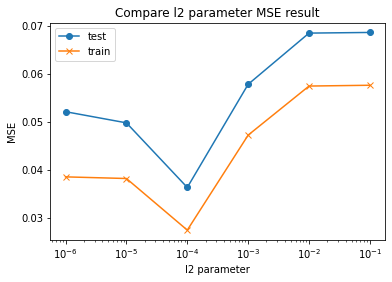

In [ ]:

plt.semilogx(values, all_test, label='test', marker='o')
plt.semilogx(values, all_train, label='train', marker='x')
plt.title('Compare l2 parameter MSE result')
plt.xlabel('l2 parameter')
plt.ylabel('MSE')
plt.legend()
plt.show()

The best l2 parameter for X_valid is 1e-4
### Retrain the model with best parameter.

In [ ]:

#Encode Layer
encoded = layers.Dense(encoding_dim, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-4))(input_data)

#Decode Layer
decoded = layers.Dense(input_size, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(1e-4))(encoded)

#Autoencoder Model 
autoencoder = keras.Model(input_data, decoded)
  
# Complie and Train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train,X_train,
                  validation_data=(X_valid, X_valid),
                  epochs=epoch,
                  batch_size=batch_size)
  
# evaluate the model
X_valid_output = autoencoder.predict(X_valid)
test_mse = mean_squared_error(X_valid, X_valid_output)

# print mse
print('MSE for Validation')
print(test_mse)

Epoch 1/30
15/15 [==============================] - 1s 18ms/step - loss: 0.0830 - val_loss: 0.0903
Epoch 2/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0844 - val_loss: 0.0890
Epoch 3/30
15/15 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0879
Epoch 4/30
15/15 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0864
Epoch 5/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0738 - val_loss: 0.0856
Epoch 6/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0720 - val_loss: 0.0839
Epoch 7/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0740 - val_loss: 0.0812
Epoch 8/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0710 - val_loss: 0.0790
Epoch 9/30
15/15 [==============================] - 0s 5ms/step - loss: 0.0639 - val_loss: 0.0773
Epoch 10/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0684 - val_loss: 0.0744
Epoch 11/30
15/15 

In [ ]:
autoencoder.summary()

Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 250)]             0         
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 1255      
_________________________________________________________________
dense_51 (Dense)             (None, 250)               1500      
Total params: 2,755
Trainable params: 2,755
Non-trainable params: 0
_________________________________________________________________


## 3. Selects the 5 most communal and 20 least communal stocks. The ticker symbols for the 2 sets of stocks should be stored in
lists called most_communal and least_communal .

In [ ]:
df = pd.DataFrame(X_valid,index=tickers)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
INO,0.039704,0.039367,0.038022,0.038358,0.045087,0.044415,0.046433,0.048116,0.044415,0.053499,0.049462,0.062921,0.076380,0.112719,0.080417,0.072005,0.090511,0.086137,0.065276,0.058546,0.053499,0.047106,0.041050,0.050808,0.047779,0.046097,0.063594,0.073351,0.075707,0.061911,0.056191,0.059892,0.066958,0.059556,0.067968,0.080417,0.077725,0.081427,0.184388,0.203903,...,0.300808,0.297106,0.288022,0.219717,0.320996,0.294415,0.315949,0.311238,0.366083,0.327389,0.305182,0.304509,0.288358,0.282974,0.275236,0.283311,0.346231,0.344886,0.351615,0.336474,0.354980,0.357672,0.343203,0.335801,0.318304,0.315949,0.305855,0.283984,0.301144,0.284993,0.294415,0.283311,0.281292,0.266824,0.272544,0.278937,0.256729,0.233849,0.236541,0.231494
ALKS,0.090340,0.092874,0.091682,0.096303,0.088849,0.095259,0.103459,0.103309,0.092129,0.081395,0.082290,0.076625,0.067979,0.060972,0.070215,0.070811,0.065593,0.064848,0.063655,0.066488,0.094514,0.090489,0.087955,0.090042,0.090042,0.090042,0.068426,0.070215,0.067829,0.083631,0.109869,0.107036,0.100030,0.102415,0.107335,0.097943,0.115981,0.121944,0.104353,0.108527,...,0.065444,0.060674,0.058736,0.072302,0.074836,0.067829,0.063506,0.070662,0.071258,0.078116,0.074240,0.076178,0.077221,0.077072,0.079159,0.080054,0.081097,0.077519,0.080501,0.085868,0.088551,0.089744,0.084526,0.084824,0.078861,0.113596,0.122838,0.131485,0.134764,0.125820,0.128354,0.133274,0.130292,0.125522,0.122242,0.125224,0.122093,0.114788,0.110167,0.102713
AERI,0.246064,0.238345,0.252393,0.233251,0.243131,0.253165,0.237882,0.231399,0.210250,0.207471,0.203149,0.207471,0.191108,0.182464,0.191571,0.186169,0.184779,0.175363,0.178450,0.175672,0.179685,0.186169,0.175517,0.175672,0.173973,0.165020,0.162705,0.159463,0.152671,0.159772,0.166255,0.192498,0.172584,0.148503,0.148348,0.121797,0.129361,0.135227,0.121797,0.130441,...,0.027323,0.024853,0.022229,0.050247,0.058814,0.060667,0.059895,0.059586,0.059123,0.060204,0.054569,0.050170,0.045153,0.048472,0.053103,0.055881,0.059895,0.050787,0.050479,0.056036,0.054492,0.056345,0.056345,0.058043,0.045230,0.048626,0.050787,0.053412,0.059586,0.057425,0.058197,0.062674,0.061747,0.081507,0.082896,0.080426,0.076258,0.065298,0.069003,0.067768
TXMD,0.137216,0.142152,0.141165,0.145114,0.148075,0.155972,0.165844,0.149062,0.142152,0.191510,0.180652,0.166831,0.158934,0.161895,0.162883,0.155972,0.148075,0.136229,0.137216,0.142152,0.167818,0.153011,0.145114,0.155972,0.169793,0.160908,0.154985,0.158934,0.153011,0.151037,0.126357,0.117473,0.101678,0.096742,0.089832,0.077986,0.080948,0.075025,0.075025,0.097730,...,0.046397,0.042448,0.034551,0.064166,0.047384,0.048371,0.038500,0.035538,0.035538,0.039487,0.042448,0.042448,0.039487,0.041461,0.046397,0.046397,0.049358,0.046397,0.044423,0.045410,0.042448,0.044423,0.038500,0.033564,0.028628,0.033564,0.032577,0.027641,0.034551,0.033564,0.031589,0.034551,0.035538,0.031589,0.032577,0.031589,0.034551,0.030602,0.032577,0.033564
ZGNX,0.823704,0.827222,0.839815,0.852778,0.875556,0.883889,0.874259,0.911852,0.882037,0.874074,0.879630,0.869815,0.829259,0.779259,0.799259,0.802593,0.792222,0.796667,0.797593,0.802778,0.845370,0.838333,0.458704,0.417778,0.422963,0.470000,0.461111,0.459815,0.419444,0.427593,0.436481,0.422407,0.398889,0.382407,0.346481,0.302593,0.328333,0.331481,0.325370,0.370556,...,0.272778,0.264074,0.261111,0.291667,0.266296,0.250185,0.247222,0.263889,0.254630,0.248889,0.235185,0.231667,0.232037,0.249074,0.256482,0.254259,0.263148,0.260741,0.262778,0.261852,0.272778,0.275556,0.260556,0.255185,0.251852,0.248519,0.233148,0.255556,0.253889,0.234259,0.239815,0.234074,0.238148,0.239630,0.231852,0.237593,0.233519,0.225556,0.231852,0.234074


In [ ]:
X_valid.shape

(118, 250)

In [ ]:
from scipy.linalg import norm

result=[]
for stock in X_valid:
  #reshape data to fit the model
  stock = stock.reshape(1,250)

  # evaluate the model
  stock_output = autoencoder.predict(stock)
  #use mse will give the same ranking
  #test_mse = mean_squared_error(stock, stock_output)
  l2_norm = norm(stock_output-stock,2)
  result.append(l2_norm)


In [ ]:
result_df = pd.DataFrame(result,index=tickers)
result_df

,0
INO,3.368670
ALKS,4.137610
AERI,3.463472
TXMD,4.156068
ZGNX,2.131560
...,...
OPK,4.169006
CCXI,3.817046
ESPR,1.885321
AMGN,4.227957


In [ ]:
most_communal=result_df.nsmallest(5,0).index.tolist()
least_communal=result_df.nlargest(20,0).index.tolist()

## 4. Prints the ticker symbols for selected stocks as follows:
Most communal 
------------- 
STK1, STK2, STK3, STK4, ... 
Least communal 
------------- 
STK6, STK7, STK8, STK9, ...

In [ ]:
print('Most communal')
print('-------------')
print(most_communal)
print("\n")
print('Least communal')
print('-------------')
print(least_communal)


Most communal
-------------
['CARA', 'AXON', 'ITCI', 'VCYT', 'CHRS']


Least communal
-------------
['PTCT', 'ASND', 'ACAD', 'PBYI', 'CLDX', 'BLCM', 'TLGT', 'ACOR', 'CMRX', 'AUPH', 'CLVS', 'ENDP', 'BMRN', 'MNKD', 'AKBA', 'AMGN', 'BPMC', 'OPK', 'TXMD', 'LGND']
